In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

# Modelling binomial distribution with GLM (Breast Cancer Data)

In [13]:
breast_cancer_df = pd.read_csv('breast_cancer_data.csv')
# Cleaning
breast_cancer_df['diagnosis_dummy'] = (breast_cancer_df['diagnosis'] == 'M').astype(int)
breast_cancer_df.drop('Unnamed: 32', inplace=True, axis=1)
breast_cancer_df['intercept'] = 1

## EDA

Text(0.5, 1.0, 'Breast Cancer Diagnosis vs. Mean Radius')

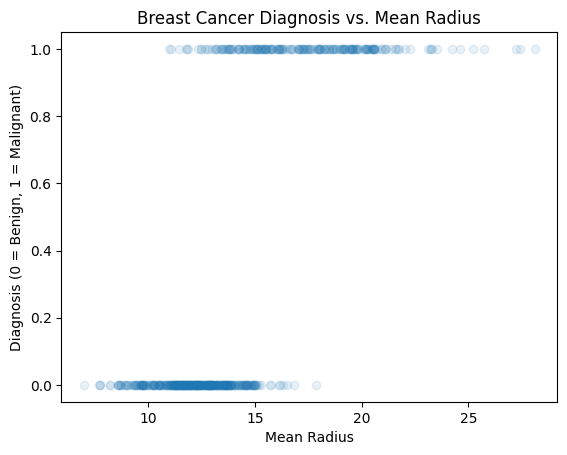

In [14]:
plt.scatter(breast_cancer_df['radius_mean'], breast_cancer_df['diagnosis_dummy'], alpha=0.1)
plt.xlabel('Mean Radius') 
plt.ylabel('Diagnosis (0 = Benign, 1 = Malignant)')  
plt.title('Breast Cancer Diagnosis vs. Mean Radius')

## Train-test split

In [33]:
breast_cancer_df_train, breast_cancer_df_test = train_test_split(breast_cancer_df, test_size=0.2, random_state=0)

## Implement using iterative WLS

In [51]:
def logistic_regression_iwls(data, y_col, x_cols, max_iter=10, tol=0.001):
    n = len(data)
    
    data = data.copy() 
    # data['intercept'] = 1
    # x_cols = ['intercept'] + x_cols
    
    X = data[x_cols].values
    y = data[y_col].values
    
    # Define the logit link function and its derivative
    def logit(p):
        return np.log(p / (1 - p))
    
    def logit_inv(eta):
        return 1 / (1 + np.exp(-eta))

    def logit_derivative(mu):
        # print(mu)
        return 1/(mu * (1 - mu))
    
    def b_double_derivative(theta):
        return n * (np.exp(theta)) / (1 + np.exp(theta))**2
    
    # Initial estimates for mu and eta using y, but perturb it else we run into numerical issues
    mu = np.where(y == 1, 0.99, 0.01)

    eta = logit(mu)
    theta = np.log(mu /(1-mu))
    
    # Initialize beta estimates
    beta = np.zeros(X.shape[1])

    beta_prev = beta
    for _ in range(max_iter):
        # Update z and weights w
        z = eta + (y - mu) * logit_derivative(mu)
        # w = 1/ (logit_derivative(mu) ** 2 * (mu * (1 - mu)))
        w = 1 / (logit_derivative(mu) ** 2 * b_double_derivative(theta))

        W = np.diag(w)
        
        XTWX_inv = np.linalg.inv(X.T @ W @ X)
        XTWZ = X.T @ W @ z
        beta = XTWX_inv @ XTWZ
        has_nan = np.any(np.isnan(beta))
        # if has_nan:
        #     print(beta_prev)
        #     return beta_prev

        # if np.max(np.abs(beta - beta_prev)) < tol:
        #     break
        eta = X @ beta
        mu = logit_inv(eta)
        beta_prev = beta
    print(beta)
    return beta

def predict(data, params, x_cols):
    data = data.copy()  # Make a copy to avoid modifying the original DataFrame
    X = data[x_cols].values
    linear_prediction = np.dot(X, params)
    pred_prob = 1 / (1 + np.exp(-linear_prediction))
    return pred_prob


x_cols = ['radius_mean']
# all_features = list(df.columns[2:-2])
# x_cols = all_features[:1]
x_cols = ['intercept'] + x_cols
params = logistic_regression_iwls(breast_cancer_df_train, 'diagnosis_dummy', x_cols, tol=0.1, max_iter=10000)

# Predict on test set
breast_cancer_df_test['pred_prob_glm'] = predict(breast_cancer_df_test, params, x_cols)

# Calculate accuracy
breast_cancer_df_test['predicted_diagnosis'] = (breast_cancer_df_test['pred_prob_glm'] > 0.5).astype(int)
accuracy_with_log_glm = (breast_cancer_df_test['predicted_diagnosis'] == breast_cancer_df_test['diagnosis_dummy']).mean()
print(f"Accuracy: {accuracy_with_log_glm}")

[-14.7545481    0.99404751]
Accuracy: 0.8947368421052632


## Implement using sm.GLM() (check that IWLS is correct)

In [35]:
import statsmodels.api as sm

model = sm.GLM(breast_cancer_df_train['diagnosis_dummy'], breast_cancer_df_train[x_cols], family=sm.families.Binomial())

# Fit the model
result = model.fit()

# Print the fitted parameters
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        diagnosis_dummy   No. Observations:                  455
Model:                            GLM   Df Residuals:                      453
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -134.40
Date:                Thu, 11 Apr 2024   Deviance:                       268.80
Time:                        23:52:37   Pearson chi2:                     394.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5128
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept     -14.7120      1.420    -10.364      

## Illustration of Results

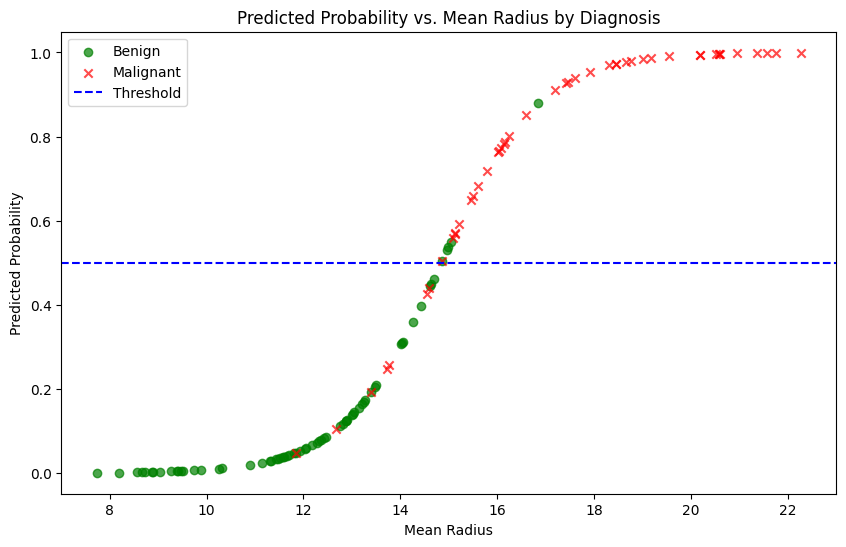

Accuracy using Logistic GLM: 0.8947368421052632


In [45]:
import matplotlib.pyplot as plt

benign = breast_cancer_df_test[breast_cancer_df_test['diagnosis_dummy'] == 0]
malignant = breast_cancer_df_test[breast_cancer_df_test['diagnosis_dummy'] == 1]

plt.figure(figsize=(10, 6))

plt.scatter(benign['radius_mean'], benign['pred_prob'], color='green', marker='o', alpha=0.7, label='Benign')

plt.scatter(malignant['radius_mean'], malignant['pred_prob'], color='red', marker='x', alpha=0.7, label='Malignant')

plt.axhline(y=0.5, color='blue', linestyle='--', label='Threshold')

plt.title('Predicted Probability vs. Mean Radius by Diagnosis')
plt.xlabel('Mean Radius')
plt.ylabel('Predicted Probability')
plt.legend()
plt.show()

print(f"Accuracy using Logistic GLM: {accuracy_with_log_glm}")

## Using OLS to predict breast cancer

In [52]:
import statsmodels.formula.api as smf

model = smf.ols(formula='diagnosis_dummy ~ radius_mean', data=breast_cancer_df_train).fit()

print(model.summary())

breast_cancer_df_test['pred_prob_ols'] = model.predict(breast_cancer_df_test[['radius_mean']])

# Threshold the predicted values to get binary outcomes
breast_cancer_df_test['predicted_diagnosis_ols'] = (breast_cancer_df_test['pred_prob_ols'] > 0.5).astype(int)

accuracy_with_ols = (breast_cancer_df_test['predicted_diagnosis_ols'] == breast_cancer_df_test['diagnosis_dummy']).mean()

print(f"Model accuracy on test set: {accuracy_with_ols}")


                            OLS Regression Results                            
Dep. Variable:        diagnosis_dummy   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     500.0
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           3.62e-75
Time:                        00:06:27   Log-Likelihood:                -143.19
No. Observations:                 455   AIC:                             290.4
Df Residuals:                     453   BIC:                             298.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.0289      0.064    -16.038      

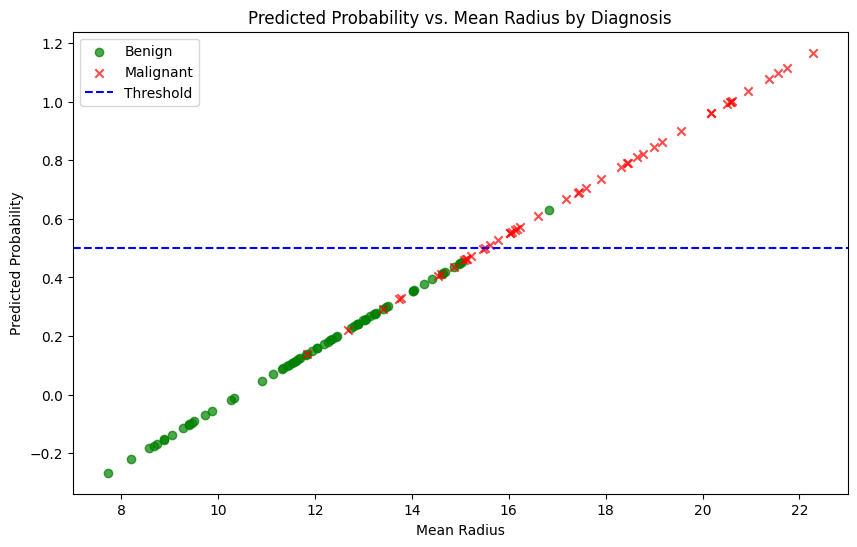

Accuracy using Logistic GLM: 0.8947368421052632


In [53]:
import matplotlib.pyplot as plt

benign = breast_cancer_df_test[breast_cancer_df_test['diagnosis_dummy'] == 0]
malignant = breast_cancer_df_test[breast_cancer_df_test['diagnosis_dummy'] == 1]

plt.figure(figsize=(10, 6))

plt.scatter(benign['radius_mean'], benign['pred_prob_ols'], color='green', marker='o', alpha=0.7, label='Benign')

plt.scatter(malignant['radius_mean'], malignant['pred_prob_ols'], color='red', marker='x', alpha=0.7, label='Malignant')

plt.axhline(y=0.5, color='blue', linestyle='--', label='Threshold')

plt.title('Predicted Probability vs. Mean Radius by Diagnosis')
plt.xlabel('Mean Radius')
plt.ylabel('Predicted Probability')
plt.legend()
plt.show()

print(f"Accuracy using Logistic GLM: {accuracy_with_log_glm}")

# Modelling Poisson Distribution with GLM (#Users on cycling lane)

In [54]:
cycle_lane_df = pd.read_csv('cycle_lane_data.csv')

In [57]:
cycle_lane_df

,Date,Unnamed: 1,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_1,Maisonneuve_2,Maisonneuve_3,Notre-Dame,...,Pont_Jacques_Cartier,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Laurent U-Zelt Test,Saint-Urbain,Totem_Laurier,University,Viger
0,01/01/2015,00:00,58,12,4,17,33.0,49,21,16,...,NaN,58,91,24,3,NaN,17,78,21,6
1,02/01/2015,00:00,75,7,5,15,30.0,113,27,9,...,NaN,109,177,32,13,NaN,11,57,77,4
2,03/01/2015,00:00,79,7,3,7,30.0,107,36,12,...,NaN,71,131,33,5,NaN,14,174,40,5
3,04/01/2015,00:00,10,1,21,0,10.0,35,29,1,...,NaN,6,11,6,1,NaN,1,20,6,0
4,05/01/2015,00:00,42,0,2,0,27.0,90,21,1,...,NaN,0,5,49,20,NaN,0,41,56,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,11/11/2015,00:00,3044,1931,2828,1393,NaN,3603,1754,1142,...,950.0,2328,3280,1210,338,4065.0,1534,1527,2860,356
315,12/11/2015,00:00,1751,930,1670,888,NaN,2048,700,675,...,467.0,1345,1877,755,180,2336.0,960,955,1777,198
316,13/11/2015,00:00,1818,906,1711,873,NaN,2115,634,477,...,482.0,1416,1980,719,204,2628.0,978,1040,1727,258
317,14/11/2015,00:00,979,759,978,322,NaN,1112,290,310,...,266.0,1061,1448,269,70,1876.0,640,805,737,73
